# Cold Start 
Retrieves the data needed to generate synthetic financial data. Run ONLY after the files have been created with Financial_TS.ipynb

## Start folder: ./TCN_TimeGAN_Repo

## Colab Code

Run ONLY if you're using Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Repositories

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Repositories


In [2]:
%cd "./TCN_TimeGAN_Repo"

/content/gdrive/MyDrive/Repositories/TCN_TimeGAN_Repo


### Installs

These may or may not be necessary

In [5]:
!pip3 install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [3]:
import os
import pandas as pd
import numpy as np
import time

from sklearn.preprocessing import MinMaxScaler
from tcn import TCN
from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (GRU, Dense, 
                                     RNN, GRUCell, Input, 
                                     Permute, Lambda)
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('white')


# Parameters

In [4]:
results_path = Path('./')
os.chdir(results_path)
from src.params_08 import ( experiment, 
                                        ## Data Parameters
                                        data_file,
                                        ts_names,
                                        start_date,
                                        end_date,

                                        ## Parameters
                                        n_seq, 
                                        seq_len,
                                        batch_size,
                                        train_steps,
                                        gamma,

                                        ##  Network Parameters
                                        hidden_dim,
                                        latent_dim,
                                        n_layers_disc,
                                        n_layers_supv,

                                        ## Generic Loss Functions
                                        mse,
                                        bce,

                                        ## Optimizers
                                        autoencoder_optimizer,
                                        embedding_optimizer,
                                        discriminator_optimizer,
                                        generator_optimizer,
                                        supervisor_optimizer,

                                        ## Pooling Parameters
                                        pooler,
                                        latent_sample_rate )

# Experiment Path

In [5]:
log_dir = results_path / f'experiment_{experiment:02}'
hdf_store = log_dir / f'TimeSeriesGAN_{experiment:02}.h5'

## Get Data

In [6]:
df = pd.read_hdf(hdf_store, 'data/real')
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


## Create Rolling Windows

In [7]:
data = []
for i in range(len(df)-seq_len): 
  data.append(scaled_data[i:i + seq_len])
  
n_windows = len(data) 

## Create TF Dataset

In [8]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [9]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

## Get synthesizer

In [10]:
synthesizer = tf.keras.models.load_model(log_dir / 'synthesizer')

## Reshape data

In [11]:
real_data = np.stack(data)
real_data.shape

(4348, 180, 6)

In [12]:
pwr2 = np.floor(np.log2(len(real_data))).astype(int)
near_len = 2**pwr2
near_len

4096

In [13]:
generated_data = np.load(log_dir / 'generated_data.npy')

In [14]:
generated_data.shape

(4096, 180, 6)

In [15]:
n_samples = 512
rng = np.random.default_rng()
idx_r = rng.choice(n_windows, n_samples)
idx_g = rng.choice(near_len, n_samples)
real_sample = real_data[idx_r,:,:]
gen_sample = generated_data[idx_g,:,:]

## Rescale

In [16]:
gen_sample = (scaler.inverse_transform(gen_sample
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
gen_sample.shape

(512, 180, 6)

In [17]:
real_sample = (scaler.inverse_transform(real_sample
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
real_sample.shape

(512, 180, 6)

## Plot sample Series


Sample Plot: 11


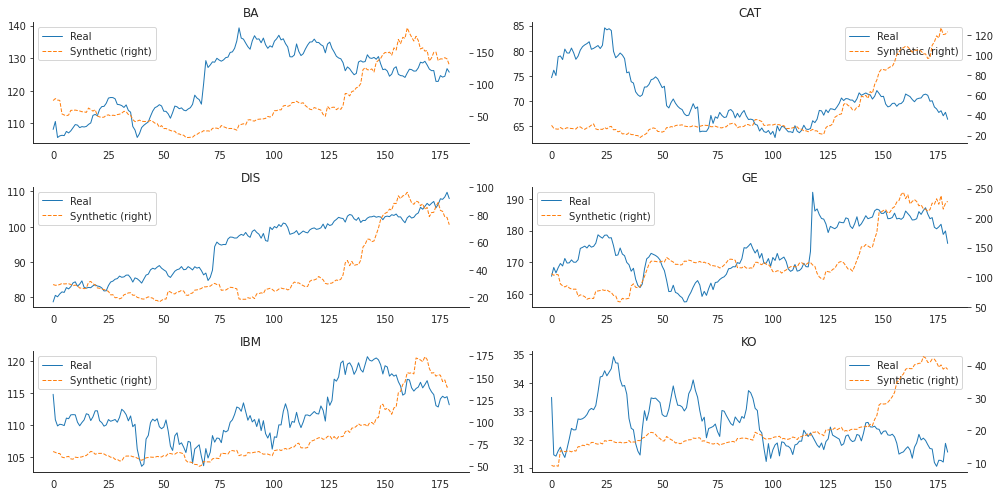


Sample Plot: 12


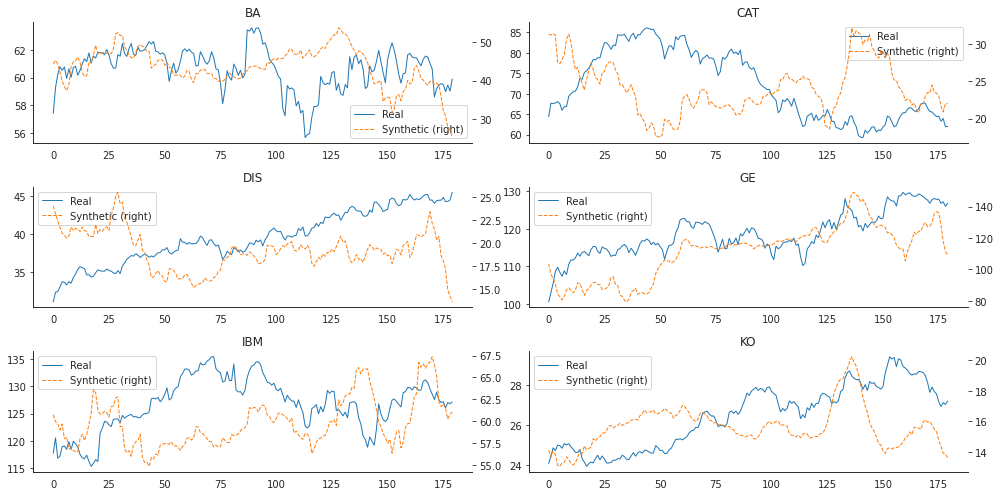


Sample Plot: 13


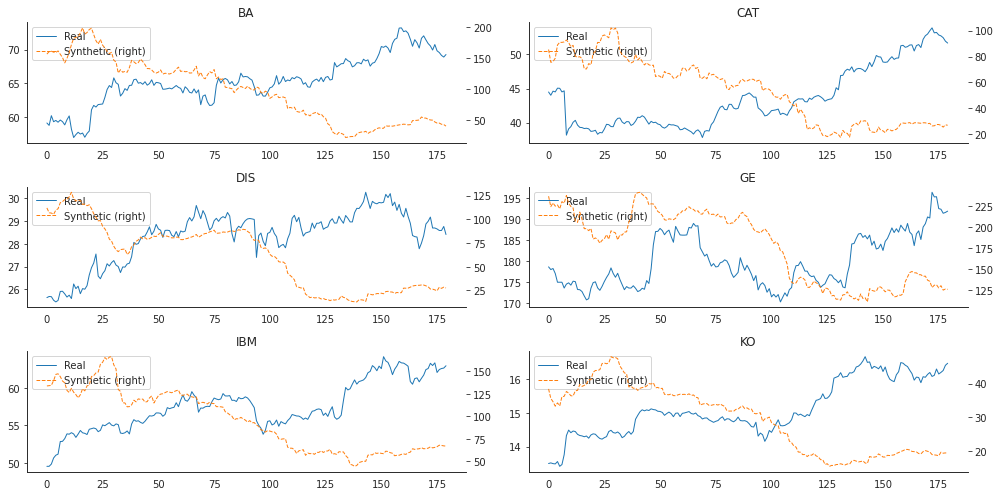


Sample Plot: 14


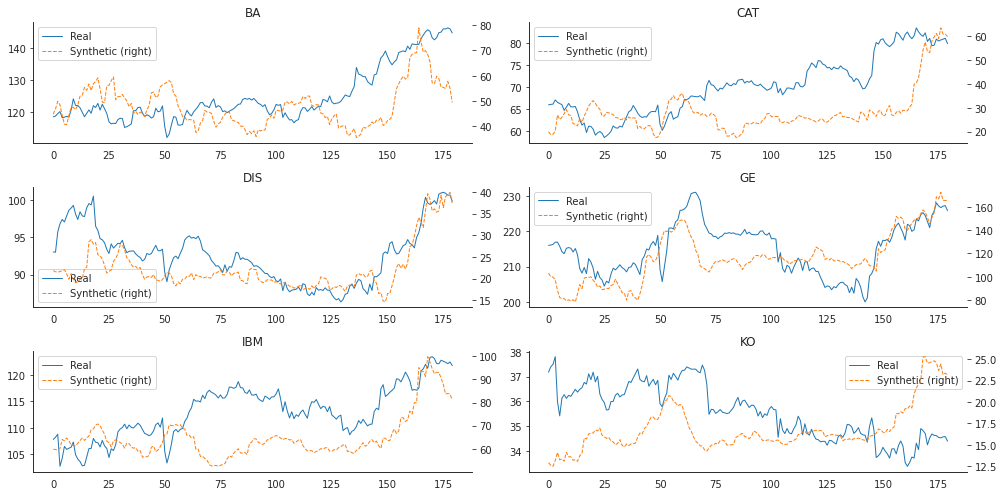


Sample Plot: 15


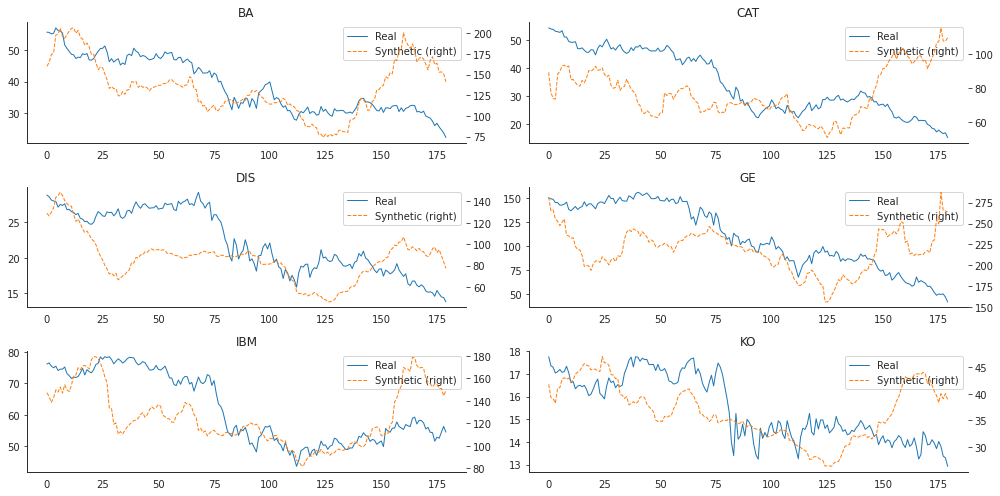

In [19]:
tickers = ts_names
n_init = 10
n_plots = 5

for n in range(n_init, n_init + n_plots):
  print("\nSample Plot: %d" % (n + 1))
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
  axes = axes.flatten()
  
  idx = np.random.randint(len(real_sample))
  synthetic = gen_sample[idx]
  real = real_sample[idx]

  for j, ticker in enumerate(tickers):
      (pd.DataFrame({'Real': real[:, j],
                    'Synthetic': synthetic[:,j]})
      .plot(ax=axes[j],
            title=ticker,
            secondary_y='Synthetic', style=['-', '--'],
            lw=1))
  sns.despine()

  fig.tight_layout()
  plt.show()
  f_name = os.path.join(log_dir, "samples", "sample_" + str(n + 1 ) + ".png")
  fig.savefig(f_name)